In [1]:
from utils_model import SwitchableDoublePathCNNModule
from utils_dataset import get_loaders
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
torch.set_float32_matmul_precision('medium')

In [3]:
output_dir = "./combined_mnist_dataset"
num_samples = 500000

In [4]:
train_dataloader, val_dataloader, test_dataloader = get_loaders(output_dir, num_samples)

In [5]:
l_model = SwitchableDoublePathCNNModule.load_from_checkpoint("checkpoints_two_models/best_model_1736941275.ckpt")
mean_model = l_model.mean_model
var_model = l_model.variance_model

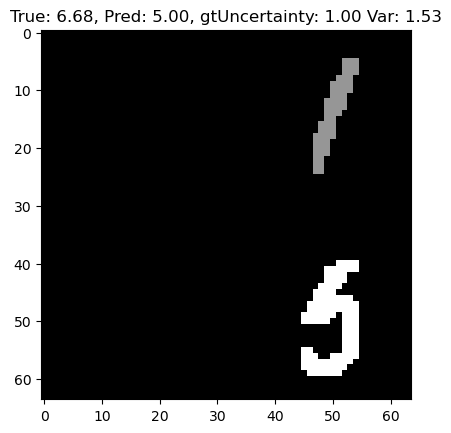

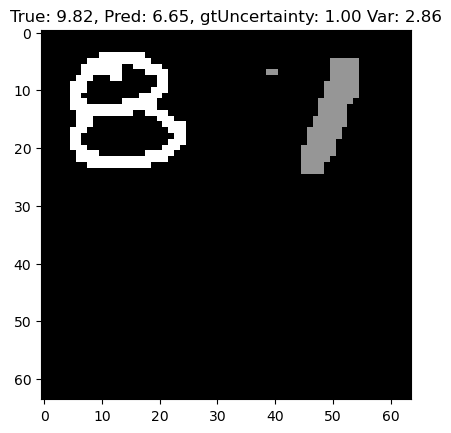

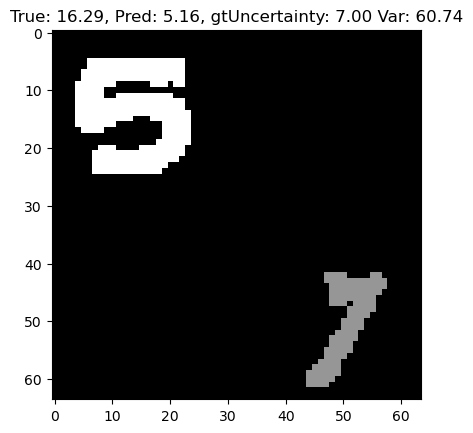

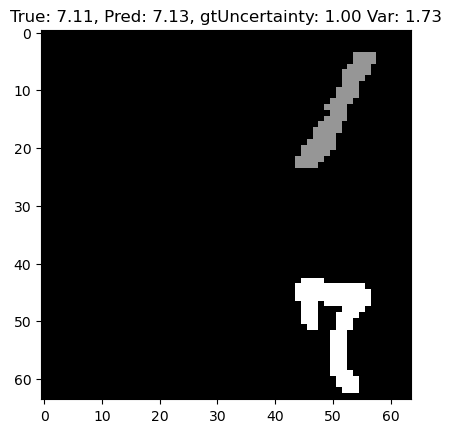

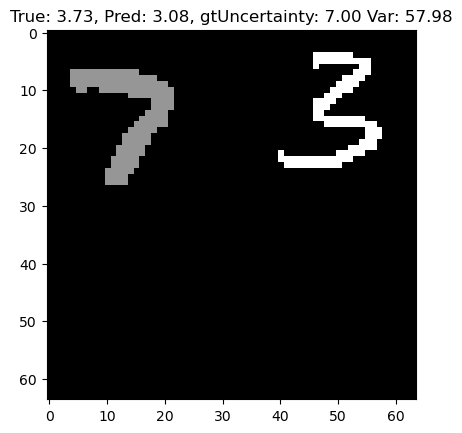

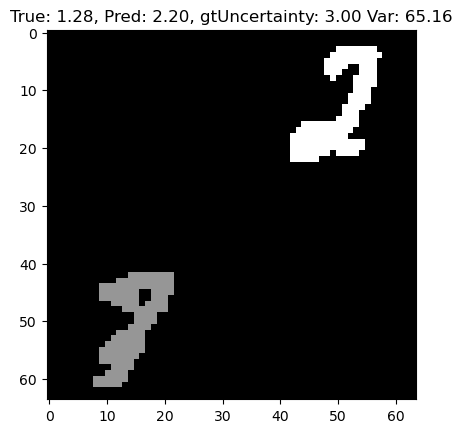

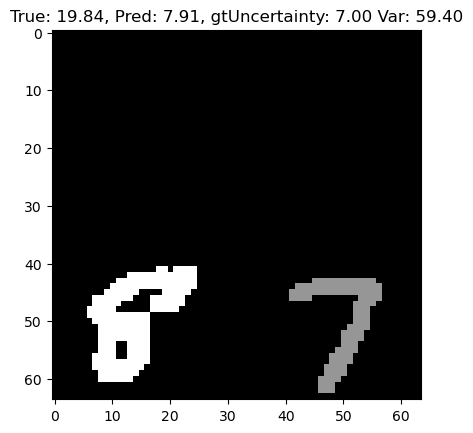

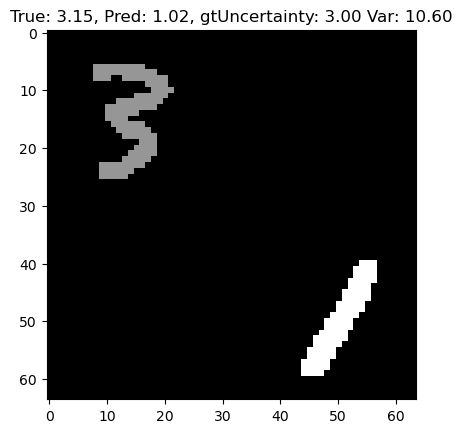

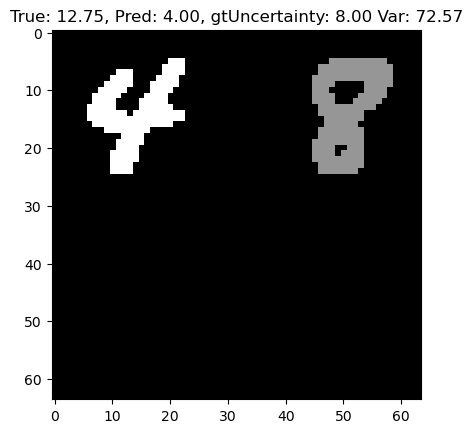

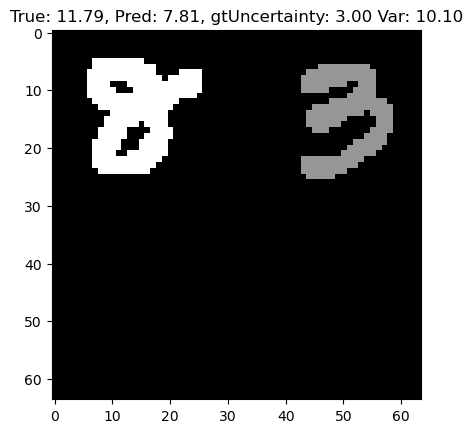

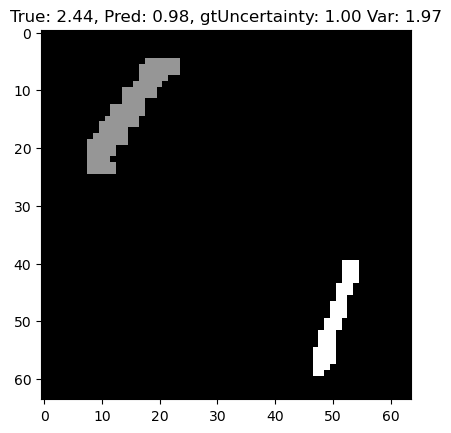

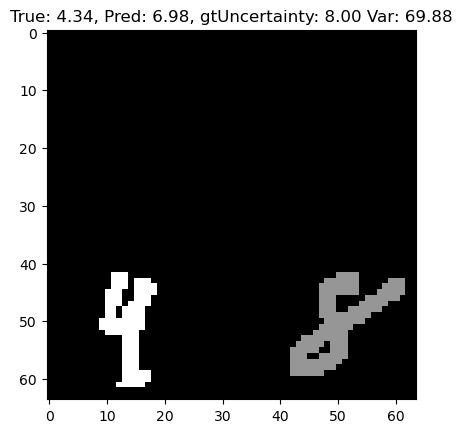

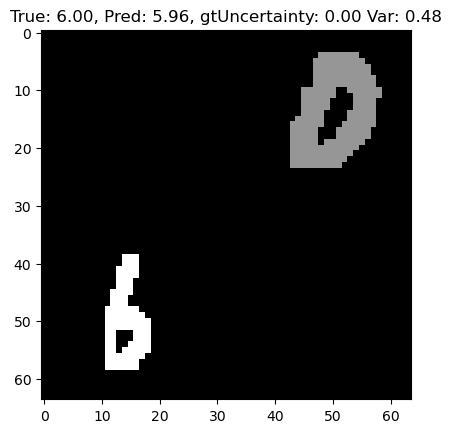

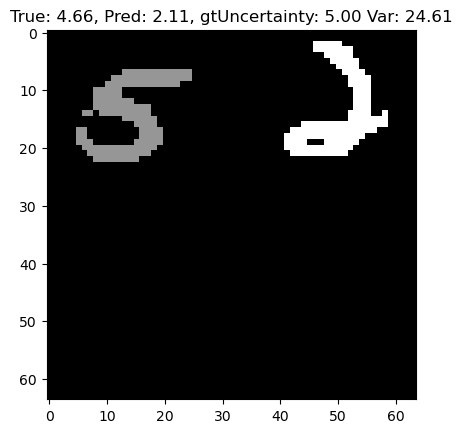

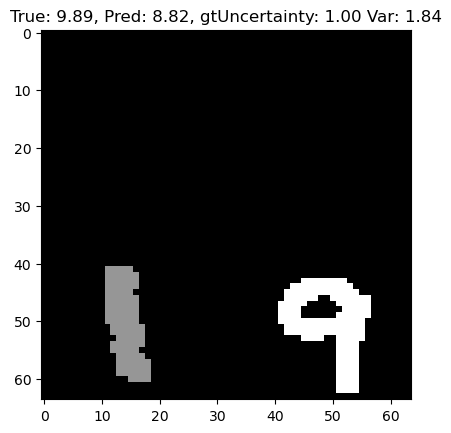

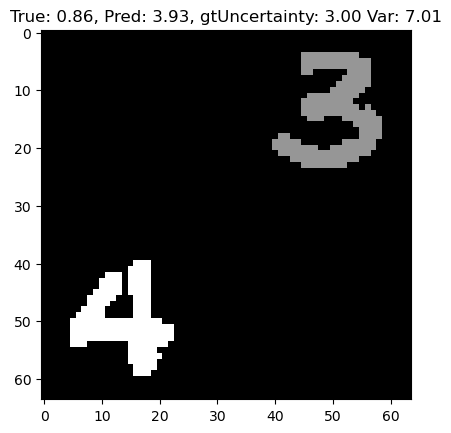

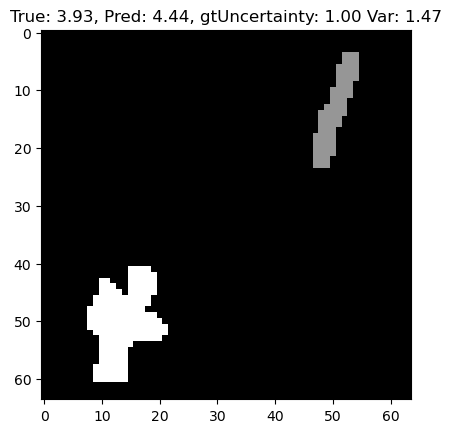

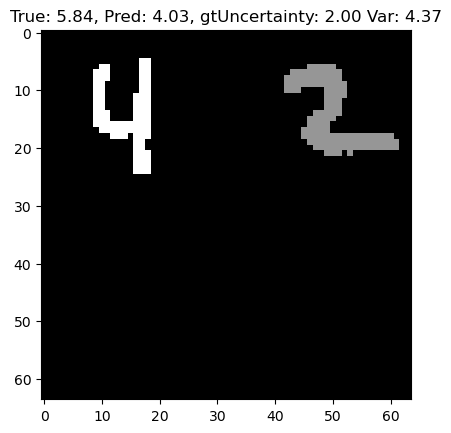

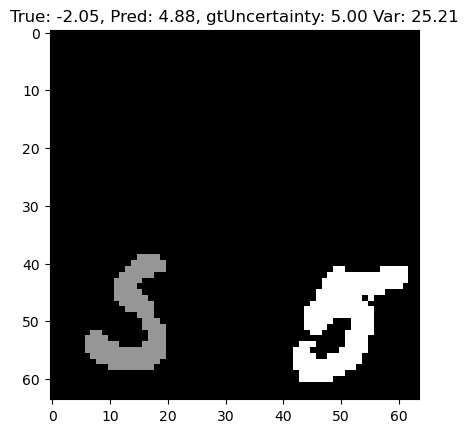

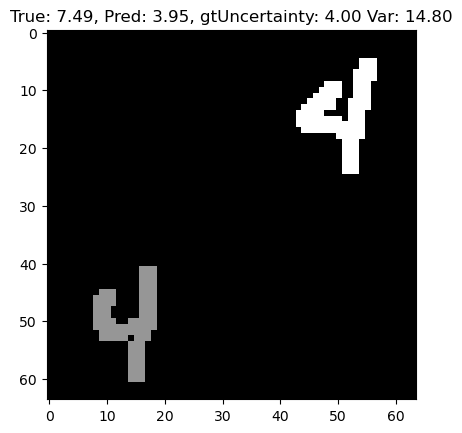

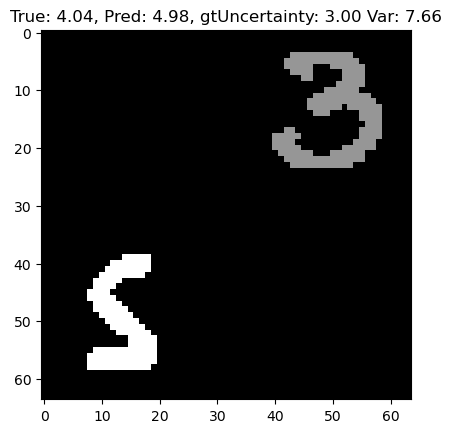

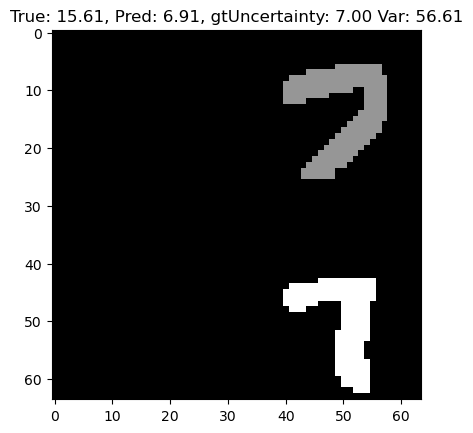

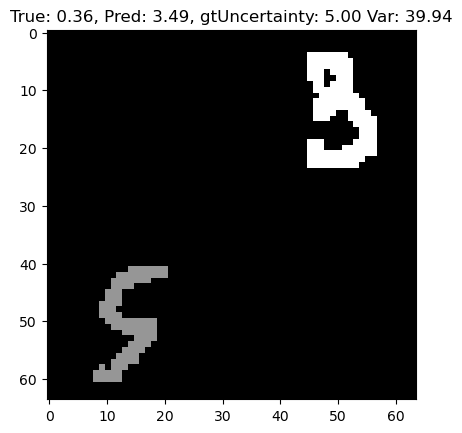

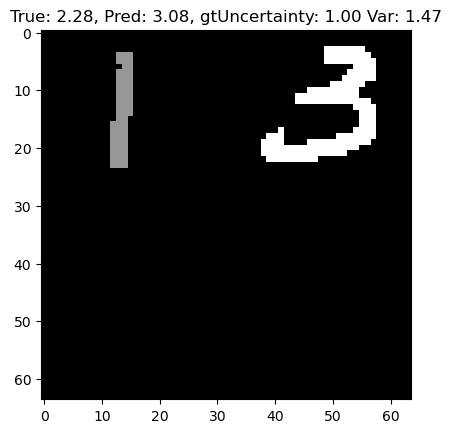

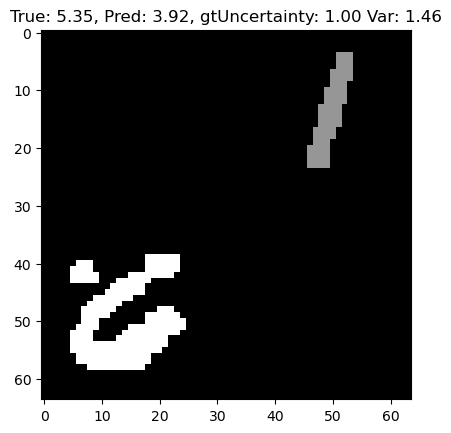

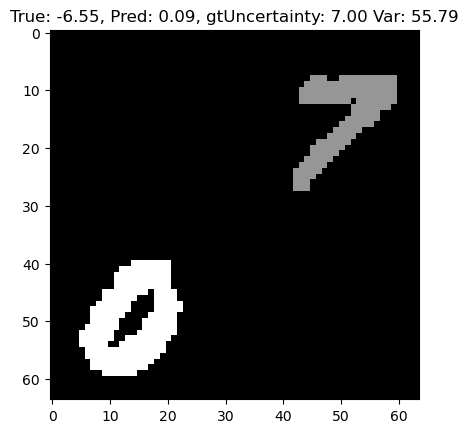

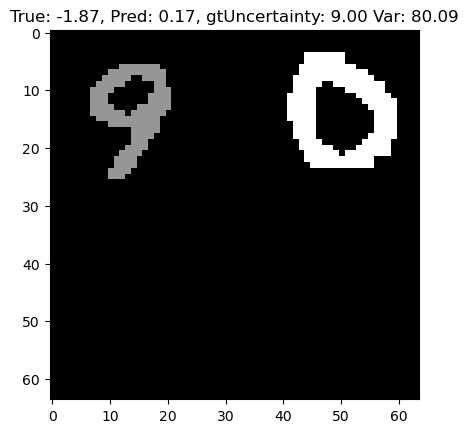

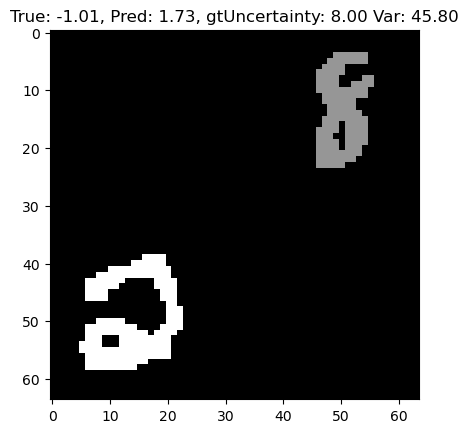

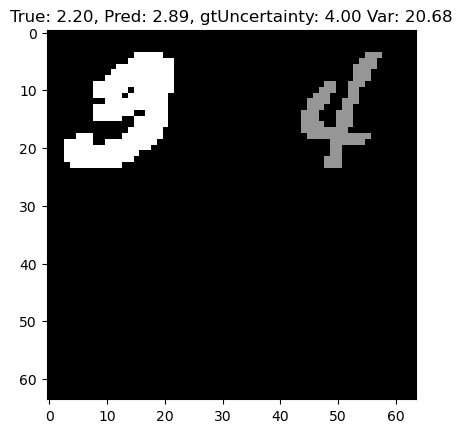

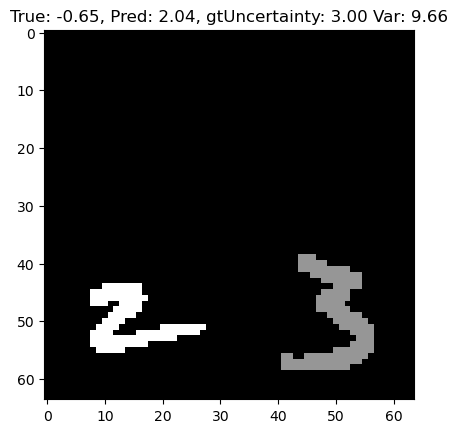

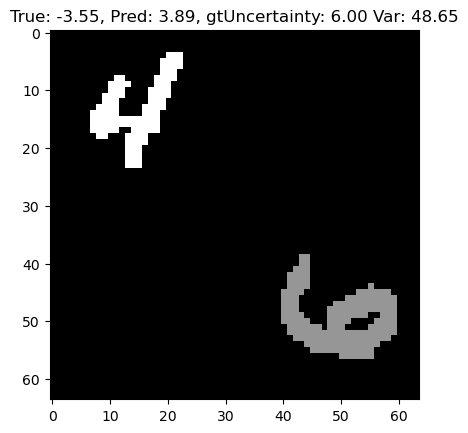

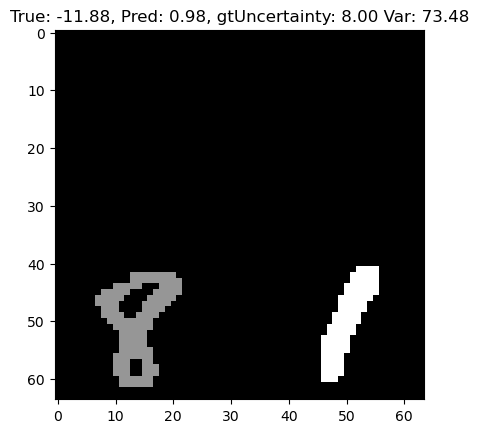

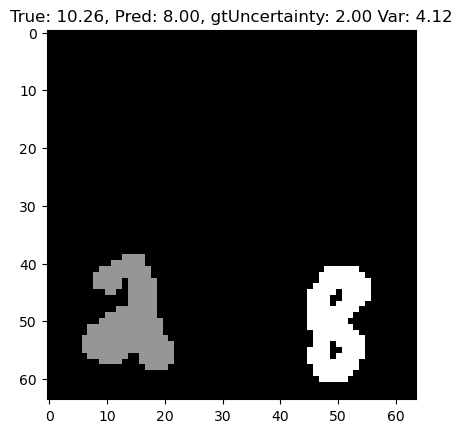

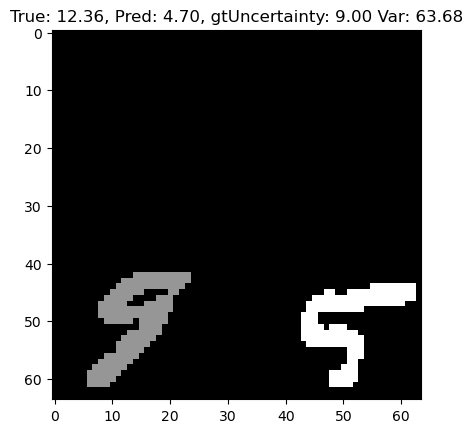

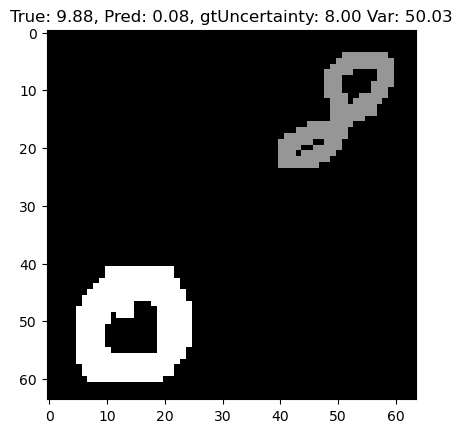

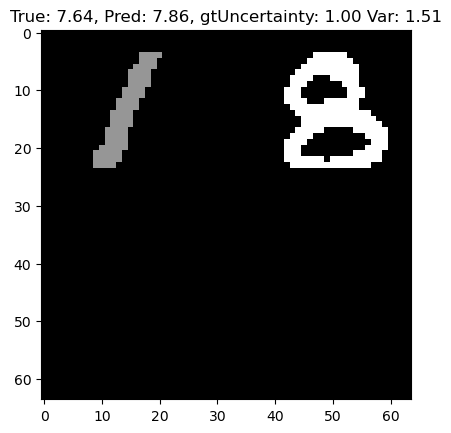

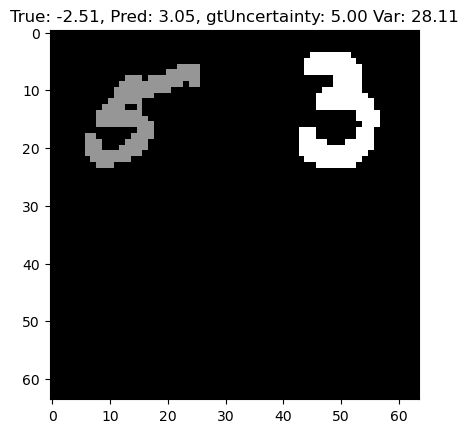

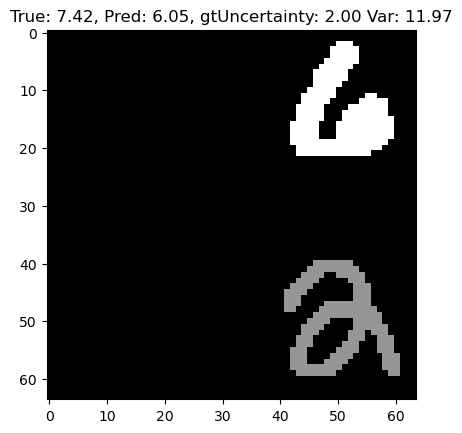

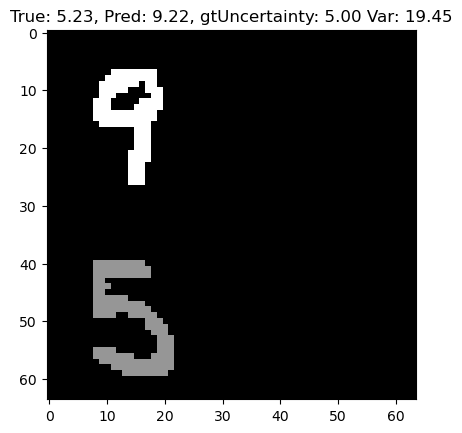

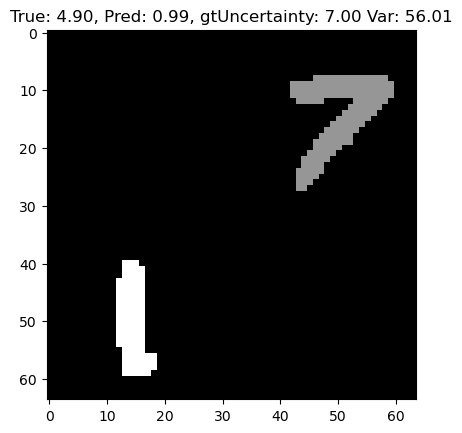

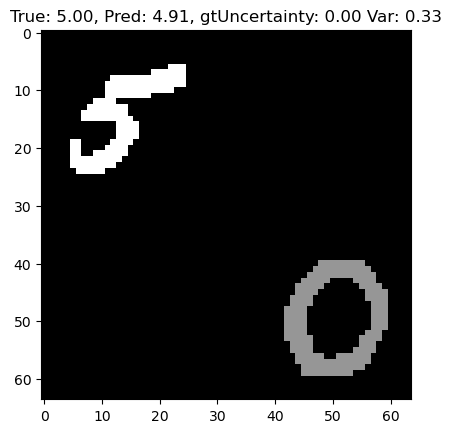

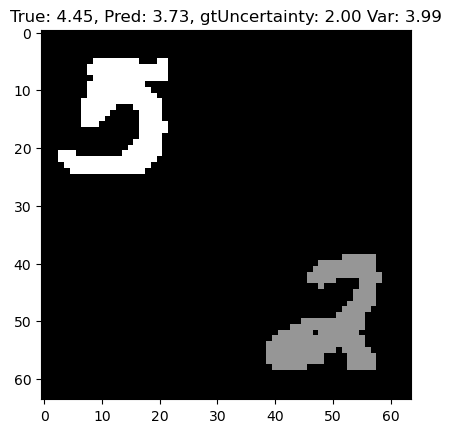

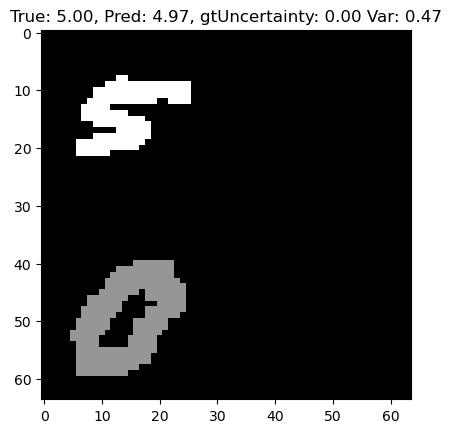

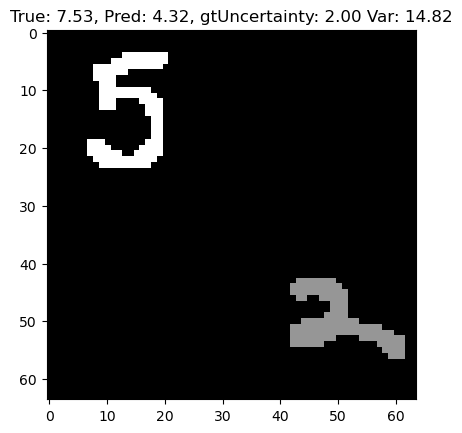

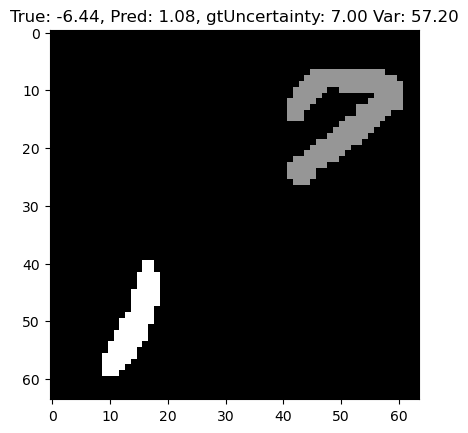

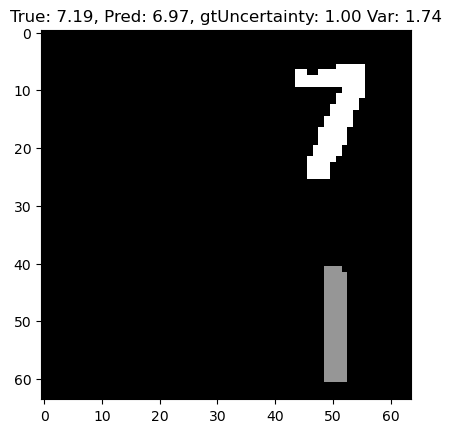

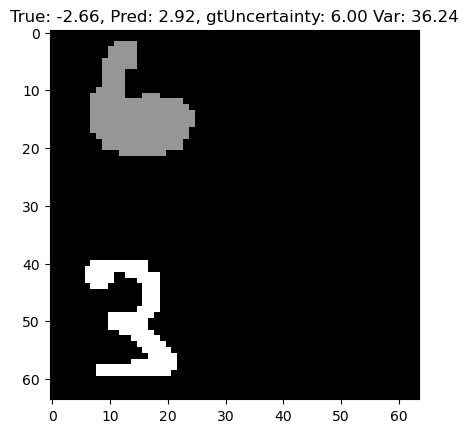

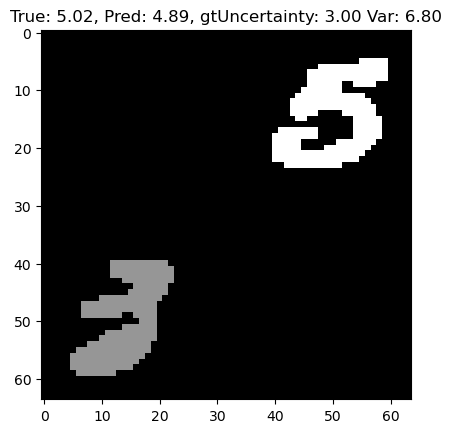

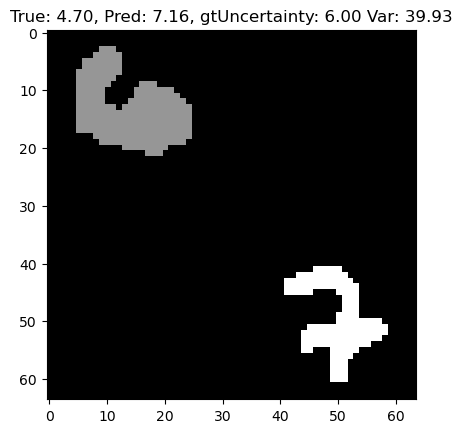

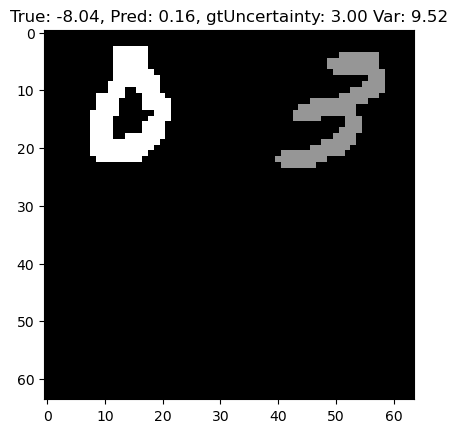

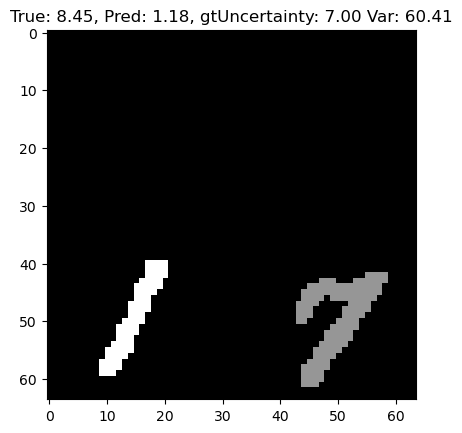

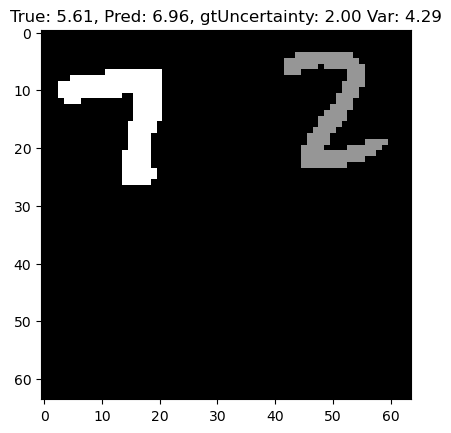

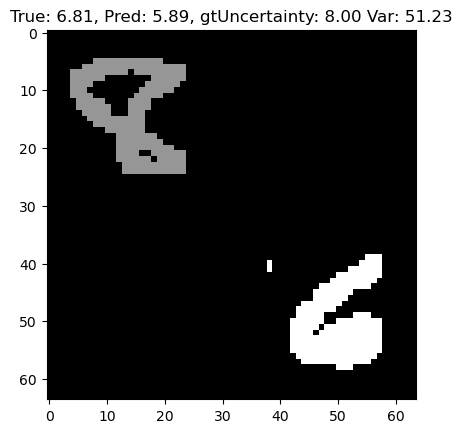

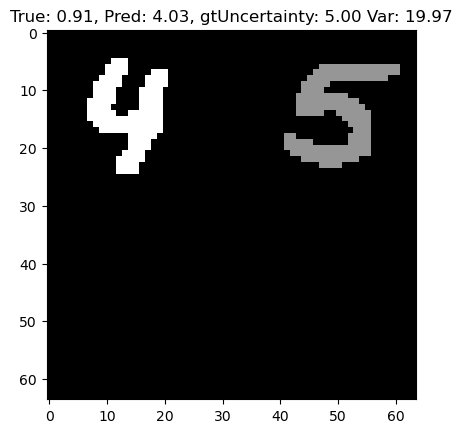

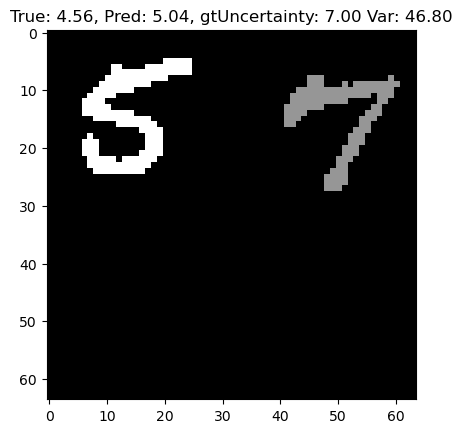

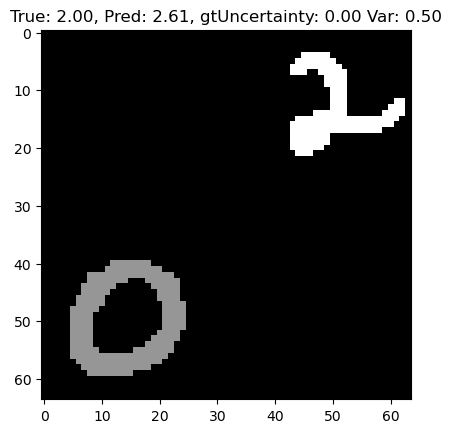

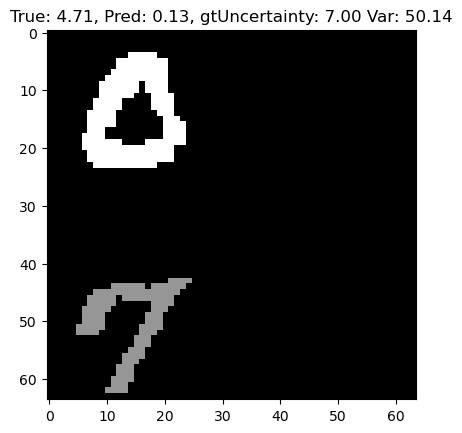

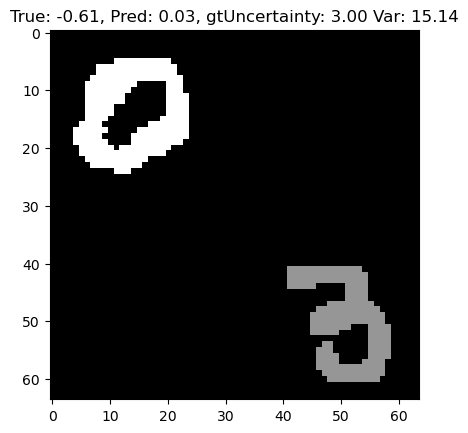

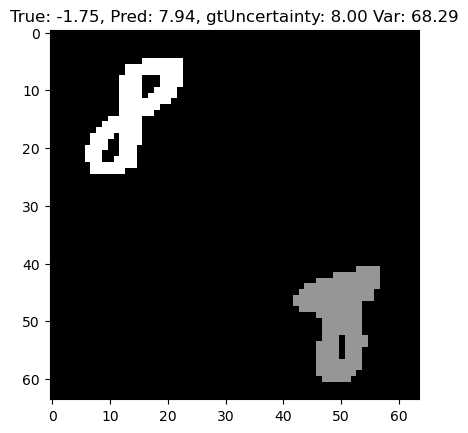

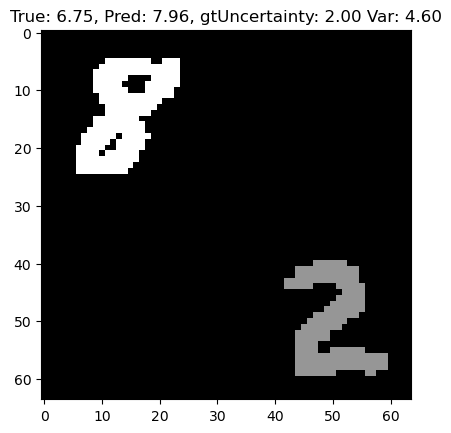

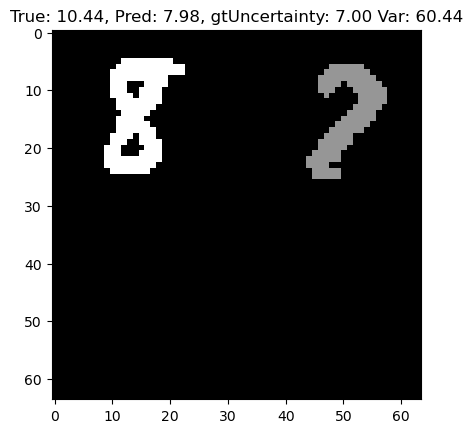

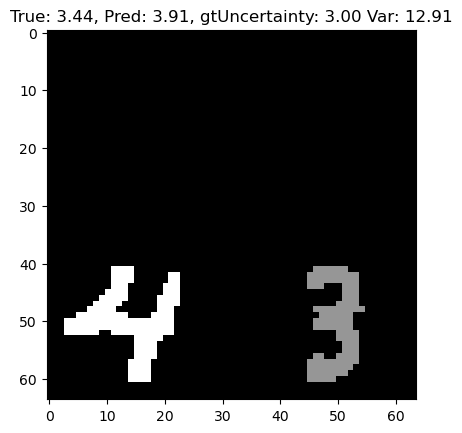

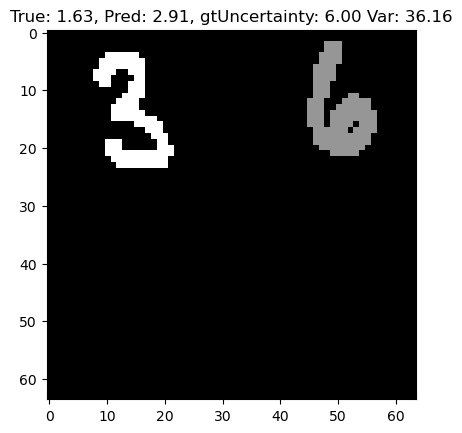

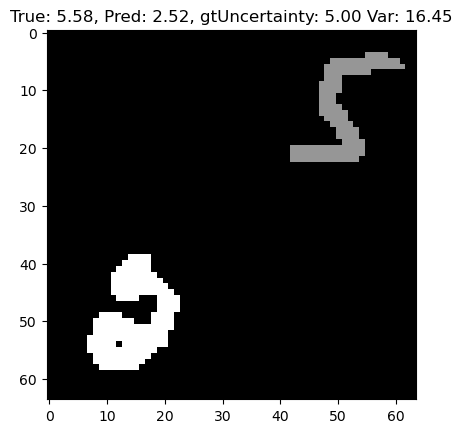

In [9]:
# Test function to visualize results
def visualize_predictions_switchable(mean_model, var_model, test_loader):
    mean_model.eval()
    var_model.eval()
    with torch.no_grad():
        for i, (images, labels, gt_uncertainty, _, _) in enumerate(test_loader):
            if i == 1:  # Visualize a few batches
                break
            
            means = mean_model(images.to(device))
            log_vars = var_model(images.to(device))
            for j in range(len(images)):
                img = images[j].squeeze().numpy()
                uncertainty = torch.exp(log_vars[j]).item()
                plt.imshow(img, cmap='gray')
                plt.title(
                    f"True: {labels[j].cpu().numpy().item():.2f}, Pred: {means[j].cpu().numpy().item():.2f}, "
                    f"gtUncertainty: {gt_uncertainty[j].numpy().item():.2f} Var: {uncertainty:.2f}"
                )
                plt.show()

# Run visualization
# test_loader = DataLoader(dataset, batch_size=8, shuffle=True)
visualize_predictions_switchable(mean_model, var_model, test_dataloader)

100%|██████████| 1563/1563 [01:51<00:00, 13.96it/s]


(100000,) (100000,)
Correlation between predicted uncertainty and ground truth uncertainty: 0.9551
(100000,) (100000,)


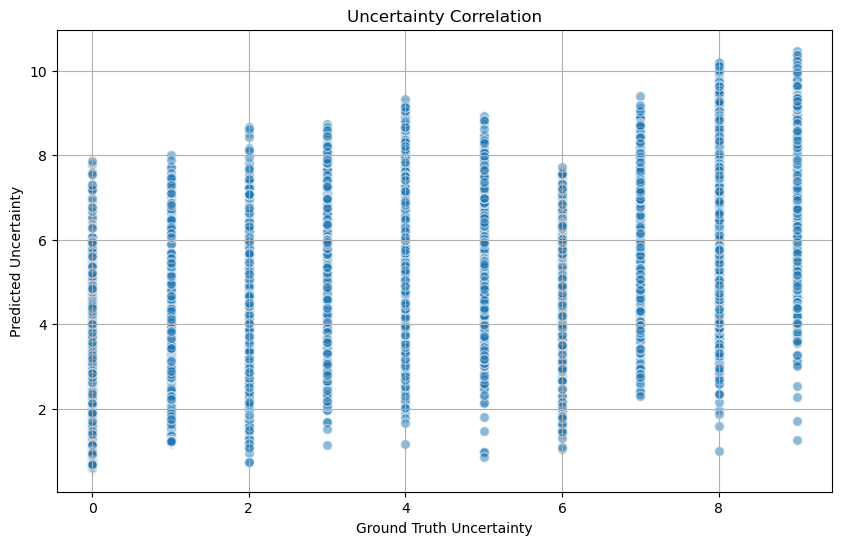

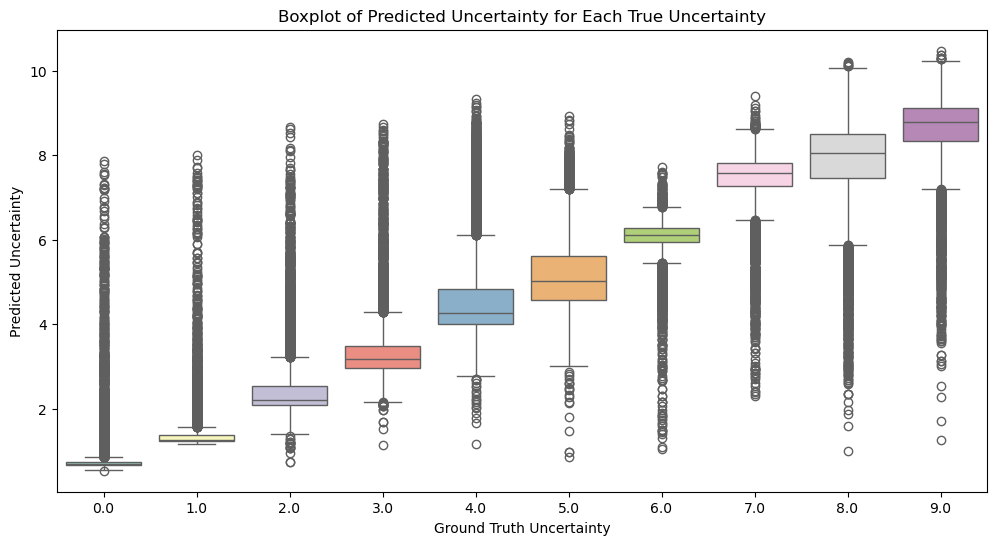

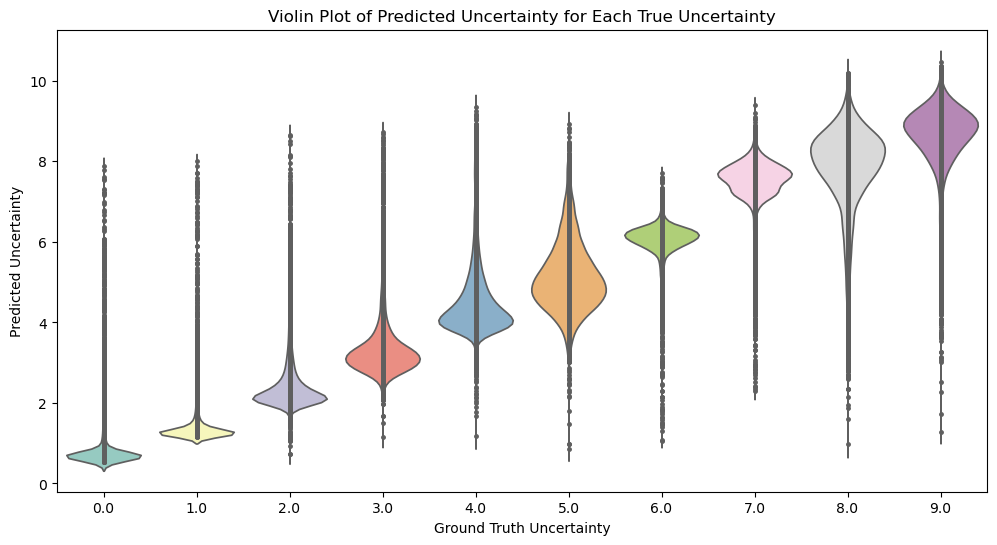

In [11]:
from tqdm import tqdm
def evaluate_uncertainty_correlation(mean_model, var_model, test_loader):
    mean_model.eval()
    var_model.eval()
    predicted_uncertainty = []
    true_uncertainty = []
    
    with torch.no_grad():
        for images, labels, gt_uncertainty, _, _ in tqdm(test_loader):
            means = mean_model(images.to(device))
            log_vars = var_model(images.to(device))
            
            # Calculate predicted uncertainty (which is the exponential of log-variance)
            predicted_uncertainty.extend(torch.exp(log_vars).cpu().numpy())  # Exponential of log variance gives uncertainty
            true_uncertainty.extend(gt_uncertainty.cpu().numpy())  # Ground truth uncertainty


    # Convert to numpy arrays for correlation calculation
    predicted_uncertainty = np.sqrt(np.array(predicted_uncertainty)).squeeze()
    true_uncertainty = np.array(true_uncertainty).squeeze()

    print(predicted_uncertainty.shape, true_uncertainty.shape)
    
    # Calculate Pearson correlation coefficient between predicted uncertainty and ground truth uncertainty
    correlation = np.corrcoef(predicted_uncertainty, true_uncertainty)[0, 1]
    
    print(f"Correlation between predicted uncertainty and ground truth uncertainty: {correlation:.4f}")
    
    # # Optionally, visualize the relationship
    # plt.scatter(true_uncertainty, predicted_uncertainty, alpha=0.5)
    # plt.xlabel('Ground Truth Uncertainty')
    # plt.ylabel('Predicted Uncertainty')
    # plt.title('Uncertainty Correlation')
    # plt.show()
     # Prepare data for seaborn
    print(predicted_uncertainty.shape, true_uncertainty.shape)
    data = {
        "True Uncertainty": true_uncertainty,
        "Predicted Uncertainty": predicted_uncertainty,
    }
    df = pd.DataFrame(data)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(true_uncertainty, predicted_uncertainty, alpha=0.5, edgecolors='w', s=50)
    plt.xlabel('Ground Truth Uncertainty')
    plt.ylabel('Predicted Uncertainty')
    plt.title('Uncertainty Correlation')
    plt.grid(True)
    plt.show()
    
    # Boxplot: Distribution of Predicted Uncertainty for each True Uncertainty
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="True Uncertainty", y="Predicted Uncertainty", hue="True Uncertainty", legend=False, data=df, palette="Set3")
    plt.xlabel('Ground Truth Uncertainty')
    plt.ylabel('Predicted Uncertainty')
    plt.title('Boxplot of Predicted Uncertainty for Each True Uncertainty')
    plt.show()
    
    # Violin Plot: Distribution of Predicted Uncertainty for each True Uncertainty
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="True Uncertainty", y="Predicted Uncertainty", hue="True Uncertainty", legend=False, data=df, palette="Set3", inner="point")
    plt.xlabel('Ground Truth Uncertainty')
    plt.ylabel('Predicted Uncertainty')
    plt.title('Violin Plot of Predicted Uncertainty for Each True Uncertainty')
    plt.show()

# Test the correlation between uncertainty and variance
evaluate_uncertainty_correlation(mean_model, var_model, test_dataloader)
